I developed the analysis pipeline in this notebook to help me understand the behavior of different Japanese text parsers, focusing specifically on lemma extraction for vocabulary study. Unsurprisingly, parsing Japanese text remains a challenging problem. LLMs tend to work fairly well in my experience, but I don't have API access to any of them, so I'm relying on more traditional methods here.

I have kept the pipeline flexible so that it can handle any number of parsers without requiring any code modifications. The main requirement is to extract and store parser output in a DataFrame that conforms to the data dictionary defined in the "Parsers" section.

I have run three text samples through this pipeline and stored all the outputs in the `outputs` folder. The file names all end with the number which corresponds to the text's sample number that generated that output. The sample numbers are written in comments above each text sample. My commentary tends to reference all outputs, not just those displayed in this notebook.

In [2]:
from upsetplot import UpSet, from_contents
import matplotlib.pyplot as plt
import pandas as pd
from sudachipy import tokenizer
from sudachipy import dictionary
import spacy
import MeCab
from janome.tokenizer import Tokenizer
from wordcloud import WordCloud
import numpy as np
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
import seaborn as sns

from collections import defaultdict
import itertools
import warnings

# override seaborn's override of matplotlib styling
plt.style.use('default')
# use kanji-friendly font for pyplot
plt.rcParams['font.family'] = 'Meiryo'
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# sample 1: description of a book on Amazon
# source: https://www.amazon.co.jp/%E5%BD%A2%E6%85%8B%E7%B4%A0%E8%A7%A3%E6%9E%90%E3%81%AE%E7%90%86%E8%AB%96%E3%81%A8%E5%AE%9F%E8%A3%85-%E5%AE%9F%E8%B7%B5%E3%83%BB%E8%87%AA%E7%84%B6%E8%A8%80%E8%AA%9E%E5%87%A6%E7%90%86%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E5%B7%A5%E8%97%A4-%E6%8B%93/dp/4764905779/355-8248816-1730863?pd_rd_w=JhYtU&content-id=amzn1.sym.2902d37c-369c-4d13-972a-9152012f37eb:amzn1.symc.8c545e6f-1019-41f8-9ab8-f016ebe76d44&pf_rd_p=2902d37c-369c-4d13-972a-9152012f37eb&pf_rd_r=1FAT5K9J258TSK3JX628&pd_rd_wg=CC3XZ&pd_rd_r=55383241-a3f0-4e43-8b78-74889b15ab57&pd_rd_i=4764905779&psc=1
# text = """あの工藤 拓が具体的に解説 !!本書は,汎用形態素解析システムMeCabを開発した著者が、言語において意味を成す最小の要素である「形態素」の解析方法について,技術者向けにその理論や実装方法を網羅的,体系的に解説する.実装や高速化なども扱う点がユニークであるが、辞書やコーパスなどの言語資源の構築・利用といった形態素解析では外せないテーマもきちんと解説している.本書を読めば,解析ツールを「ブラックボックス」として使っている人も中身を理解したうえで拡張・改良できる道筋ができ,ひいては独自の辞書の作成を目指せるようになる.C++11を使った具体的な実装方法も掲載.AI・自然言語処理関係の技術者,研究者には必携の書である."""

# sample 2: first paragraph from a Japanese translation of a Sherlock Holmes novel
# source: https://tadoku.org/japanese/book/41615/#bd-look-inside
# text = """みなさん、探偵シャーロックホームズを知っています。シャーロックホームズが出てくる推理小説は、今から百年ほど前にイギリスの小説家アーサーコナンドイル（一八五九～一九三〇年）によって書かれました。ロンドンにあるホームズの家に事件で困っている人たちが訪ねてきます。ホームズはその人たちから話を聞き、事件が起こった場所に出かけます。そして、友達のワトソンに手伝ってもらいながら、どんなに難しい事件でも解決してしまいます。ホームズの話は世界中で愛され、今もたくさんの人に読まれています。この『まだらの紐』は、六十あるホームズの話の中でも、とても人気がある作品です。他に『赤毛クラブ』も有名で、多読用図書「にほんご多読ブックスvol．６」（大修館書店）にも収録されています。"""

# sample 3: sample from a news article
# source: https://www3.nhk.or.jp/news/html/20250912/k10014921411000.html
text = """12日夜、和歌山県の沖合を飛行していたアメリカのユナイテッド航空の旅客機が関西空港に緊急着陸し、乗客が脱出用シューターを使って緊急脱出するトラブルがあり、5人が軽いけがをしました。飛行中、貨物室で火災を知らせる警報が出たということで、国の運輸安全委員会はトラブルの原因などを調べることにしています。国土交通省関西空港事務所によりますと、12日午後6時半ごろ、成田からフィリピンのセブに向かっていたアメリカのユナイテッド航空32便、ボーイング737型機が和歌山県の沖合およそ200キロ、上空およそ1万メートルを飛行中、後部にある貨物室で火災が起きたことを知らせる警報が操縦室に表示されました。"""

# Parsers

I've stored the outputs of each parser into their own DataFrame:

| Feature           | Data Type | Description                                                                                                       |
|:------------------|:----------|:------------------------------------------------------------------------------------------------------------------|
| method            | string    | The parser used for the row.                                                                                      |
| surface           | string    | The parsed token as it appears in the original document.                                                          |
| index             | int       | The string index at which the parsed token begins.                                                                |
| KWIC              | string    | Keyword In Context: The text in the original document which surrounds the parsed token.                           |
| lemma             | string    | The dictionary form of the parsed token.                                                                          |
| reading           | string    | The pronunciation of the parsed token, written in katakana.                                                       |
| major_pos         | string    | Major part of speech, e.g. noun, verb, adjective.                                                                 |
| minor_pos         | string    | A more detailed part-of-speech subcategory.                                                                       |
| conjugation_type  | string    | The token's paradigm, e.g. godan, ichidan, suru-verb. Only appies to inflectable words, e.g. verbs or adjectives. |
| conjugation_form  | string    | The token's grammatical form, e.g. dictionary form, continuative, terminal. Only applies to inflectable words.    |

## SudachiPy
[SudachiPy](https://pypi.org/project/SudachiPy/)

`pip install sudachipy`

Need to install a dictionary. [sudachidict information](https://github.com/WorksApplications/SudachiDict).\
`pip install sudachidict_small`: includes only the vocabulary of UniDic\
`pip install sudachidict_core`: includes basic vocabulary (default)\
`pip install sudachidict_full`: includes miscellaneous proper nouns

In [4]:
def find_kwic(index):
    """keyword in context: the text surrounding the keyword in the original document"""
    buffer = 8
    start = index
    if index + buffer > len(text):
        end = len(text)
    else:
        end = index + buffer

    return start, end

tokenizer_obj = dictionary.Dictionary().create()
mode = tokenizer.Tokenizer.SplitMode.C

sudachi_tokens = tokenizer_obj.tokenize(text, mode)

sudachi_data = []
for token in sudachi_tokens:
    pos = token.part_of_speech()

    index = find_kwic(token.begin())

    sudachi_data.append({
        'method': 'SudachiPy',
        'surface': token.surface(),
        'index': token.begin(),
        'KWIC': text[index[0]:index[1]],
        'lemma': token.dictionary_form(),
        'reading': token.reading_form(),
        # part_of_speech returns a tuple:
        # (major POS, minor POS1, minor POS2, minor POS3, conjugation type, conjugation form)
        'major_pos': pos[0] if pos[0] != '*' else None,
        'minor_pos': pos[1] if pos[1] != '*' else None,
        'conjugation_type': pos[4] if pos[4] != '*' else None,
        'conjugation_form': pos[5] if pos[5] != '*' else None,
    })

sudachi_df = pd.DataFrame(sudachi_data)

display(sudachi_df.head())

,method,surface,index,KWIC,lemma,reading,major_pos,minor_pos,conjugation_type,conjugation_form
0,SudachiPy,12,0,12日夜、和歌山,12,イチニ,名詞,数詞,None,None
1,SudachiPy,日,2,日夜、和歌山県の,日,ニチ,名詞,普通名詞,None,None
2,SudachiPy,夜,3,夜、和歌山県の沖,夜,ヨル,名詞,普通名詞,None,None
3,SudachiPy,、,4,、和歌山県の沖合,、,、,補助記号,読点,None,None
4,SudachiPy,和歌山県,5,和歌山県の沖合を,和歌山県,ワカヤマケン,名詞,固有名詞,None,None


## MeCab

[MeCab](https://pypi.org/project/mecab-python3/)

`pip install mecab-python3`

Windows requires Microsoft Visual C++ Redistributable, apparently, so may need to install that if you run into problems.

Need to install a dictionary. Documentation (previous link) recommends `unidic`.\
`pip install unidic-lite` ([github](https://github.com/polm/unidic-lite))\
`pip install unidic` ([github](https://github.com/polm/unidic-py)). May need to run `python -m unidic download` afterwards.

In [5]:
mecab = MeCab.Tagger()

mecab_result = mecab.parseToNode(text)

mecab_data = []
pos = 0
mecab_pos = set()
while mecab_result:
    surface = mecab_result.surface
    if surface:  # skip BOS/EOS
        feature = mecab_result.feature.split(',')

        # capture index of surface from original string
        start = text.find(surface, pos)
        end = start + len(surface)
        pos = end

        index = find_kwic(start)

        if len(feature) > 7:
            lemma = feature[7].split('-')[0] if '-' in feature[7] else feature[7]
            reading = feature[6]
        else:
            lemma = None
            reading = None

        mecab_data.append({
            'method': 'MeCab',
            'surface': mecab_result.surface,
            'lemma': lemma,
            'index': start,
            'KWIC': text[index[0]:index[1]],
            'reading': reading,
            'major_pos': feature[0],
            'minor_pos': feature[1] if feature[1] != '*' else None,
            'conjugation_type': feature[4] if feature[4] != '*' else None,
            'conjugation_form': feature[5] if feature[5] != '*' else None,
        })

    mecab_result = mecab_result.next

mecab_df = pd.DataFrame(mecab_data)

display(mecab_df.head())

,method,surface,lemma,index,KWIC,reading,major_pos,minor_pos,conjugation_type,conjugation_form
0,MeCab,12,None,0,12日夜、和歌山,None,名詞,数詞,None,None
1,MeCab,日,日,2,日夜、和歌山県の,カ,接尾辞,名詞的,None,None
2,MeCab,夜,夜,3,夜、和歌山県の沖,ヨル,名詞,普通名詞,None,None
3,MeCab,、,、,4,、和歌山県の沖合,,補助記号,読点,None,None
4,MeCab,和歌山,ワカヤマ,5,和歌山県の沖合を,ワカヤマ,名詞,固有名詞,None,None


## spaCy

[spaCy](https://spacy.io/api)

`pip install spacy`

[spaCy Japanese models](https://spacy.io/models/ja)\
`python -m spacy download ja_core_news_sm`\
`python -m spacy download ja_core_news_md`\
`python -m spacy download ja_core_news_lg`\
`python -m spacy download ja_core_news_trf`

In [6]:
nlp = spacy.load("ja_core_news_sm")

spacy_doc = nlp(text)

spacy_data = []
for token in spacy_doc:
    tags = token.tag_.split('-')

    index = find_kwic(token.idx)

    inflection = token.morph.get('Inflection')

    conjugation_type = inflection[0].split(';')[0] if inflection else None
    conjugation_form = inflection[0].split(';')[1] if inflection else None

    spacy_data.append({
        'method': 'spaCy',
        'surface': token.text,
        'index': token.idx,
        'KWIC': text[index[0]:index[1]],
        'lemma': token.lemma_,
        'reading': token.morph.get('Reading')[0],
        'major_pos': tags[0] if len(tags) > 0 else None,
        'minor_pos': tags[1] if len(tags) > 1 else None,
        'conjugation_type': conjugation_type,
        'conjugation_form': conjugation_form
    })

spacy_df = pd.DataFrame(spacy_data)

display(spacy_df.head())

,method,surface,index,KWIC,lemma,reading,major_pos,minor_pos,conjugation_type,conjugation_form
0,spaCy,12,0,12日夜、和歌山,12,イチニ,名詞,数詞,None,None
1,spaCy,日,2,日夜、和歌山県の,日,ニチ,名詞,普通名詞,None,None
2,spaCy,夜,3,夜、和歌山県の沖,夜,ヨル,名詞,普通名詞,None,None
3,spaCy,、,4,、和歌山県の沖合,、,、,補助記号,読点,None,None
4,spaCy,和歌山,5,和歌山県の沖合を,和歌山,ワカヤマ,名詞,固有名詞,None,None


## Janome

[Janome](https://janome.mocobeta.dev/en/)\
[Janome API](https://janome.mocobeta.dev/reference/)

`pip install janome`

Janome use mecab-ipadic-2.7.0-20070801 as the built-in dictionary.

In [7]:
tokenizer = Tokenizer()

janome_tokens = tokenizer.tokenize(text, wakati=False)

janome_data = []
pos = 0
for token in janome_tokens:
    speech = token.part_of_speech.split(',')
    surface = token.surface

    # capture index of surface from original string
    start = text.find(surface, pos)
    end = start + len(surface)
    pos = end

    index = find_kwic(start)

    janome_data.append({
        'method': 'Janome',
        'surface': surface,
        'index': start,
        'KWIC': text[index[0]:index[1]],
        'lemma': token.base_form,
        'reading': token.reading,
        'major_pos': speech[0],
        'minor_pos': speech[1] if speech[1] != '*' else None,
        'conjugation_type': token.infl_type if token.infl_type != '*' else None,
        'conjugation_form': token.infl_form if token.infl_form != '*' else None
    })

janome_df = pd.DataFrame(janome_data)

display(janome_df.head())

,method,surface,index,KWIC,lemma,reading,major_pos,minor_pos,conjugation_type,conjugation_form
0,Janome,12,0,12日夜、和歌山,12,*,名詞,数,None,None
1,Janome,日,2,日夜、和歌山県の,日,ニチ,名詞,接尾,None,None
2,Janome,夜,3,夜、和歌山県の沖,夜,ヨル,名詞,副詞可能,None,None
3,Janome,、,4,、和歌山県の沖合,、,、,記号,読点,None,None
4,Janome,和歌山,5,和歌山県の沖合を,和歌山,ワカヤマ,名詞,固有名詞,None,None


# Comparing Methods

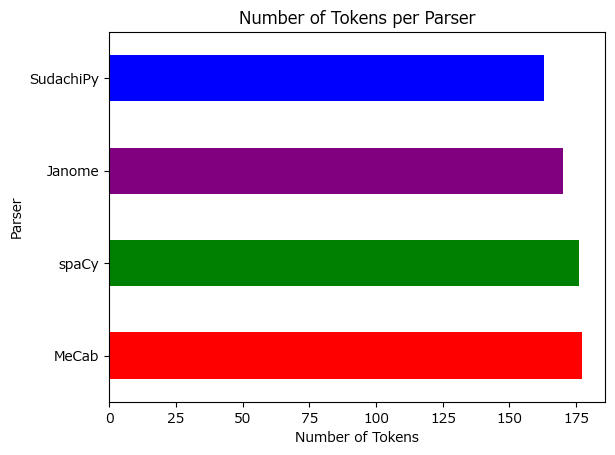

In [8]:
parsers = pd.concat([mecab_df, sudachi_df, spacy_df, janome_df], ignore_index=True)

# assign each parser a color for consistency across plots
parser_colors = {
    'MeCab': 'red',
    'SudachiPy': 'blue',
    'spaCy': 'green',
    'Janome': 'purple'
}

important_major_pos = ['名詞', '副詞', '形容詞', '動詞', '形状詞', '代名詞', '接続詞', '連体詞', '接尾辞']
# important_minor_pos = ['普通名詞', '一般', '非自立可能', '助動詞語幹', '数詞']

counts = parsers['method'].value_counts()
counts.plot(kind='barh', color=[parser_colors[method] for method in counts.index])
plt.title("Number of Tokens per Parser")
plt.xlabel("Number of Tokens")
plt.ylabel("Parser")
plt.show()

## Lemma Sets

As my primary use-case is lemma extraction, I first examined the sets of lemmas that the different parsers produced for the same text. To compare them, I first used an UpSet plot.

**Reading an UpSet plot:**\
An UpSet plot shows the same information as a Venn diagram but is more suitable when there are more than three sets.

- **Left horizontal bars:** show the total number of items in each set
- **Single dots:** elements unique to the dot's associated set. For example, given sets $\mathcal{A}$, $\mathcal{B}$, and $\mathcal{C}$, if there is a single dot to the right of $\mathcal{A}$, this represents $\mathcal{A} - \left( \mathcal{B} \cup \mathcal{C} \right)$ (elements only in $\mathcal{A}$).
- **Connected dots with a line:** represent exclusive intersections. For example, a line connecting the dots for $\mathcal{A}$ and $\mathcal{C}$ represents $\left( \mathcal{A} \cap \mathcal{C} \right) - \mathcal{B}$ (elements shared between $\mathcal{A}$ and $\mathcal{C}$, but not in $\mathcal{B}$).
- **Top vertical bars:** indicate the size of each intersection or exclusive subset

**Interpretation of Results:**\
When looking at the UpSet plots across the three text samples, three things stood out to me:
1) MeCab is always the largest exclusive set.
2) Janome varies the most: its exclusive set size fluctuates relative to the others depending on the sample.
3) SudachiPy and spaCy exclusive set sizes are among the smallest.

[spaCy incorporates SudachiPy](https://spacy.io/usage/v2-3) into its pipeline as of version 2.3, which I believe explains why the spaCy and SudachiPy exclusive lemma sets are among the smallest: they already have a lot of overlap with each other. This is further supported by the Jaccard score between the two. However, it's worth noting that in one text sample, Janome is closer to both SudachiPy and spaCy than they are to each other, though just barely.

At this point, I don't know enough about how Janome and MeCab are built to speculate about their behavior, but results later in the pipeline offer more insight.


MeCab and SudachiPy Jaccard: 0.5
MeCab and spaCy Jaccard: 0.67
MeCab and Janome Jaccard: 0.57
SudachiPy and spaCy Jaccard: 0.75
SudachiPy and Janome Jaccard: 0.76
spaCy and Janome Jaccard: 0.81


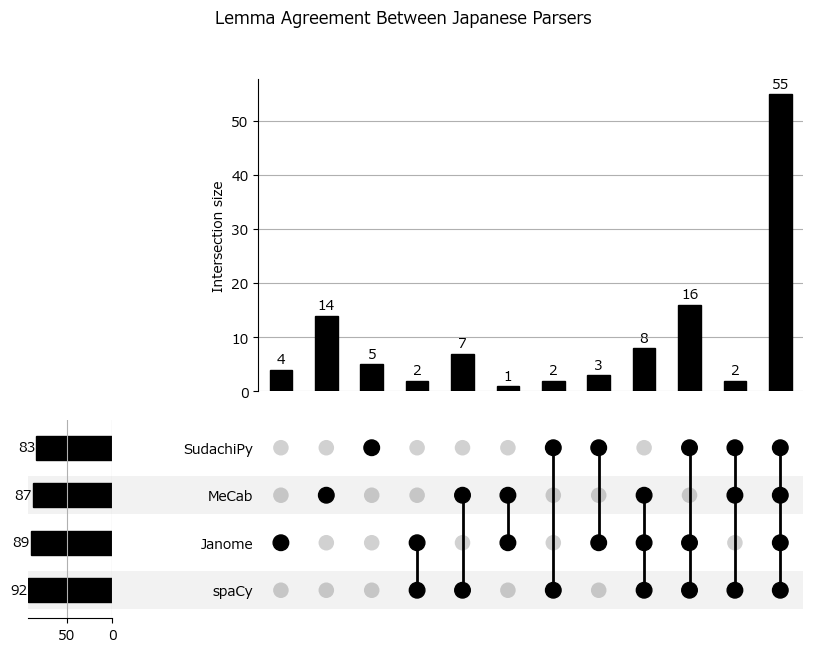

In [9]:
# jaccard similarity
def jaccard(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return round(intersection / union if union > 0 else 0, 2)

lemma_sets =  {
        method: set(parsers.loc[parsers['method'] == method, 'lemma']) for method in parsers['method'].unique()
    }

for (name1, lemmas1), (name2, lemmas2) in itertools.combinations(lemma_sets.items(), 2):
    print(f'{name1} and {name2} Jaccard: {jaccard(lemmas1, lemmas2)}')

lemma_upset_data = from_contents(lemma_sets)

UpSet(lemma_upset_data, subset_size='count', show_counts=True).plot()
plt.gcf().set_size_inches(10, 7)
plt.suptitle('Lemma Agreement Between Japanese Parsers')
plt.show()

Here are the items in the exclusive subsets, plus the items in the intersection of all sets.

In [10]:
def compare_all(dataframe):
    if dataframe['method'].nunique() < 2:
        raise ValueError('Need at least 2 parsers')

    lemma_sets =  {
        method: set(dataframe.loc[(dataframe['method'] == method) & (dataframe['major_pos'].isin(important_major_pos)), 'lemma'])
        for method in dataframe['method'].unique()
    }

    overlap = set.intersection(*lemma_sets.values())
    print(f'Intersection ({len(overlap)} items):\n{overlap}\n')

    for name, lemma in lemma_sets.items():
        others = [l for n, l in lemma_sets.items() if n != name]
        unique = lemma - set.union(*others)
        print(f'{name} only ({len(unique)} items):\n{unique}\n')

compare_all(parsers)

Intersection (39 items):
{'上空', '便', '軽い', '貨物', '夜', '午後', '飛行', '中', 'キロ', '使う', '調べる', 'ユナイテッド', 'ボーイング', 'セブ', '起きる', '火災', 'シューター', '室', '乗客', '緊急', '国', '出る', '機', 'アメリカ', 'メートル', '脱出', '向かう', '用', '後部', 'トラブル', 'フィリピン', '表示', '航空', '警報', '原因', '人', '型', '日', '着陸'}

MeCab only (14 items):
{None, '有る', 'ナリタ', '怪我', '因る', '居る', '沖合い', '頃', 'カンサイ', '言う', '凡そ', '為る', '事', 'ワカヤマ'}

SudachiPy only (5 items):
{'関西空港', '国土交通省', '運輸安全委員会', '操縦室', '和歌山県'}

spaCy only (0 items):
set()

Janome only (4 items):
{'交通省', '知らせる', '1', 'れる'}



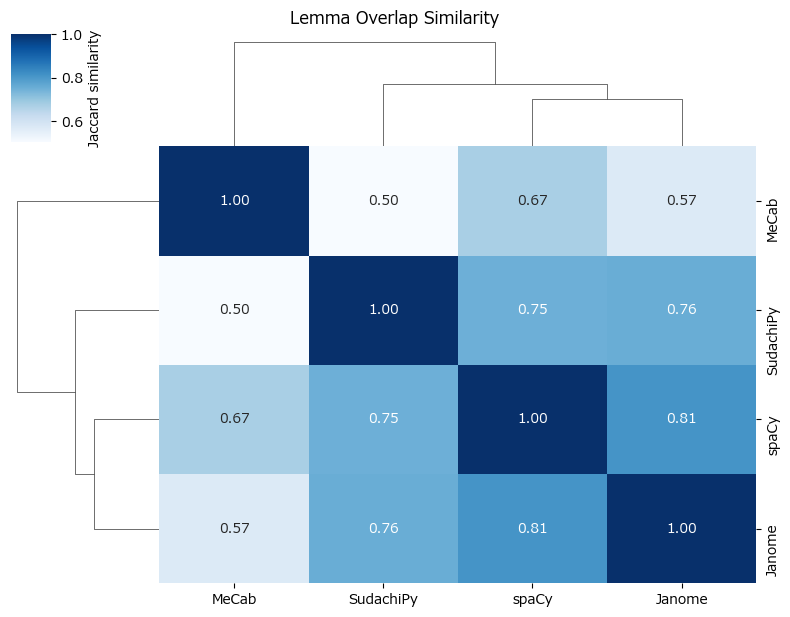

In [11]:
def plot_parser_similarity_subplots(dataframe):
    """
    Plot dendrogram+heatmap for lemma overlap similarity.

    Args:
        dataframe (pd.DataFrame): must contain ['method', 'lemma'].
    """
    methods = dataframe['method'].unique()

    if len(methods) < 2:
        raise ValueError('Need at least 2 parsers')

    lemma_sets = {m: set(dataframe.loc[dataframe['method'] == m, 'lemma']) for m in methods}

    # Check for empty lemma sets
    empty_methods = [m for m, lemmas in lemma_sets.items() if len(lemmas) == 0]
    if empty_methods:
        print(f"Warning: The following methods have no lemmas: {empty_methods}")

    sim_matrix_lemma = pd.DataFrame(
        np.zeros((len(methods), len(methods))), index=methods, columns=methods
    )
    for m1 in methods:
        for m2 in methods:
            inter = len(lemma_sets[m1] & lemma_sets[m2])
            union = len(lemma_sets[m1] | lemma_sets[m2])
            sim_matrix_lemma.loc[m1, m2] = inter / union if union > 0 else 0

    # Better approach for distance conversion to handle floating point precision
    dist_matrix_lemma = np.maximum(0, 1 - sim_matrix_lemma)
    linkage_lemma = linkage(squareform(dist_matrix_lemma.values, checks=False), method="average")

    g1 = sns.clustermap(
        sim_matrix_lemma,
        row_linkage=linkage_lemma,
        col_linkage=linkage_lemma,
        cmap="Blues",
        annot=True,
        fmt=".2f",
        cbar_kws={"label": "Jaccard similarity"},
        figsize=(8, 6)
    )
    g1.fig.suptitle("Lemma Overlap Similarity", y=1.02)

    plt.show()

plot_parser_similarity_subplots(parsers)

In [12]:
# Add a column to parsers DataFrame that shows the other parsers that parsed the same lemma
lemma_to_methods = {}
for method, lemmas in lemma_sets.items():
    for lemma in lemmas:
        if lemma not in lemma_to_methods:
            lemma_to_methods[lemma] = []
        lemma_to_methods[lemma].append(method)

def get_methods(lemma, current_method):
    methods = lemma_to_methods.get(lemma, [])
    other_methods = [m for m in methods if m != current_method]
    return other_methods if other_methods else None

# Add the new column
# other_methods should show the exclusive intersection between themselves and method because other_methods was built with lemma_sets, which contains the exclusive intersections
parsers['other_methods'] = parsers.apply(lambda row: get_methods(row['lemma'], row['method']), axis=1)

parsers.head()

,method,surface,lemma,index,KWIC,reading,major_pos,minor_pos,conjugation_type,conjugation_form,other_methods
0,MeCab,12,None,0,12日夜、和歌山,None,名詞,数詞,None,None,None
1,MeCab,日,日,2,日夜、和歌山県の,カ,接尾辞,名詞的,None,None,"[SudachiPy, spaCy, Janome]"
2,MeCab,夜,夜,3,夜、和歌山県の沖,ヨル,名詞,普通名詞,None,None,"[SudachiPy, spaCy, Janome]"
3,MeCab,、,、,4,、和歌山県の沖合,,補助記号,読点,None,None,"[SudachiPy, spaCy, Janome]"
4,MeCab,和歌山,ワカヤマ,5,和歌山県の沖合を,ワカヤマ,名詞,固有名詞,None,None,None


## Parts of Speech

My first attempt to understand the discrepancies between the parsers' sets of lemmas was to look at the parts of speech.

**Major parts of speech observations:**
- In terms of the counts for each major POS, MeCab is much more similar to the other methods than I would expect, given that it had more unique lemmas than the other methods. This suggests to me that MeCab parsed the text in roughly the same way as the other methods, but that it assigned different lemmas to the parsed tokens.
- Janome appears to disagree the most with the other three methods, though there is still broad agreement. Across the three samples, Janome finds more nouns than the other methods.
- SudachiPy and spaCy tend to track closely with each other, except when it comes to 接尾辞 (suffixes) and 名詞 (nouns), with spaCy finding more of both than SudachiPy across the samples.

**Minor parts of speech observations:**
- There isn't as much agreement among parsers between minor POS labels as I'd like. It makes it harder to analyze this aspect of the data.
- Sometimes the differences are only in label choice. For example, Janome uses 数 while the others use 数詞, but both mean numeral.
- Other times, the differences run deeper. For example, Janome uses the label サ変接続 (s-stem irregular conjugation connection), which does not have an equivalent in the other parsers.

There's opportunity here to analyze the parsers just on minor POS labels alone, but I'm not convinced that'll help me with my fundamental goal of understanding lemma extraction. I'll return here if necessary.

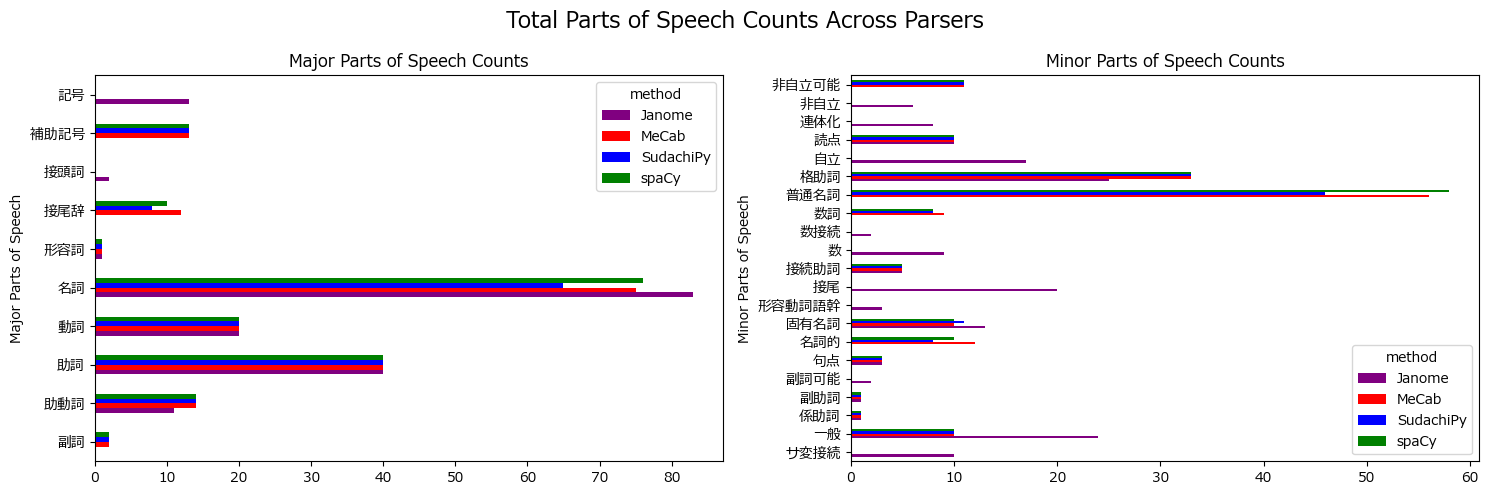

In [13]:
def pos_bar_plots(dataframe):
    methods = dataframe['method'].unique()

    if len(methods) < 1:
        raise ValueError('Need at least 1 parser')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    major_crosstab = pd.crosstab(dataframe['major_pos'], dataframe['method'])
    minor_crosstab = pd.crosstab(dataframe['minor_pos'], dataframe['method'])

    major_colors = [parser_colors[method] for method in major_crosstab.columns]
    minor_colors = [parser_colors[method] for method in minor_crosstab.columns]

    major_crosstab.plot(kind='barh', title='Major Parts of Speech Counts', color=major_colors, ax=ax[0])
    minor_crosstab.plot(kind='barh', title='Minor Parts of Speech Counts', color=minor_colors, ax=ax[1])

    ax[0].set_ylabel('Major Parts of Speech')
    ax[1].set_ylabel('Minor Parts of Speech')

    plt.suptitle('Total Parts of Speech Counts Across Parsers', fontsize=16)

    plt.tight_layout()
    plt.show()

pos_bar_plots(parsers)

 ## Timeline Plots

These plots directly show how and where in the text the different parsers disagree. To create them, I filtered the DataFrames to contain only the tokens that fall under the major part-of-speech categories I defined earlier in this notebook, in the `important_major_pos` list (this filtration is why the timelines aren't continuous). Because I'm extracting lemmas for vocabulary study, I only care about those parts of speech that generally fall under the broad category of vocabulary, and don't care at this time if parsers disagree on other elements. These parts of speech are:

- 名詞: noun
- 代名詞: pronoun
- 副詞: adverb
- 動詞: verb
- 形容詞: い-adjective
- 形状詞: な-adjective
- 連体詞: adnominal adjective
- 接続詞: conjunction
- 接尾辞: suffix

In the first timeline plot, the red highlights show where the parsers tokenized the text differently, with the labels showing how it was tokenized for each parser. The second plot shows the same timeline plot, but the orange highlights show where the parsers lemmatized the text differently, with the labels showing the parsers' lemmas. I find the plots very informative, but they can get cluttered, so I've printed the results in plain text beneath each plot as well. These are also saved in TXT files in the plots folder.

### Token Disagreements

This plot explains the differences in the part-of-speech counts shown in the previous bar charts, and the different overall token counts shown in this notebook's first bar chart. Put simply, some parsers divide some words into multiple tokens, while other parsers keep the same words as single tokens.

Observations:

- MeCab and spaCy are more fine-grained, tending to split off suffixes (e.g. 具体 + 的), and often break compound words (自然 + 言語 + 処理).
- SudachiPy has configurable granularity. The default (which I'm using here) doesn't split up longer words (具体的, 自然言語処理, 関西空港).
- Janome is more varied in its output. It tends to behave more like MeCab and spaCy in that it split off suffixes (though not always; for example, it tends to split off 県 but not 所), and tends to break compound words (though, again, not always; for example, it kept 大修館書店 as one token, where the others broke it up into 大修 + 館 + 書店).

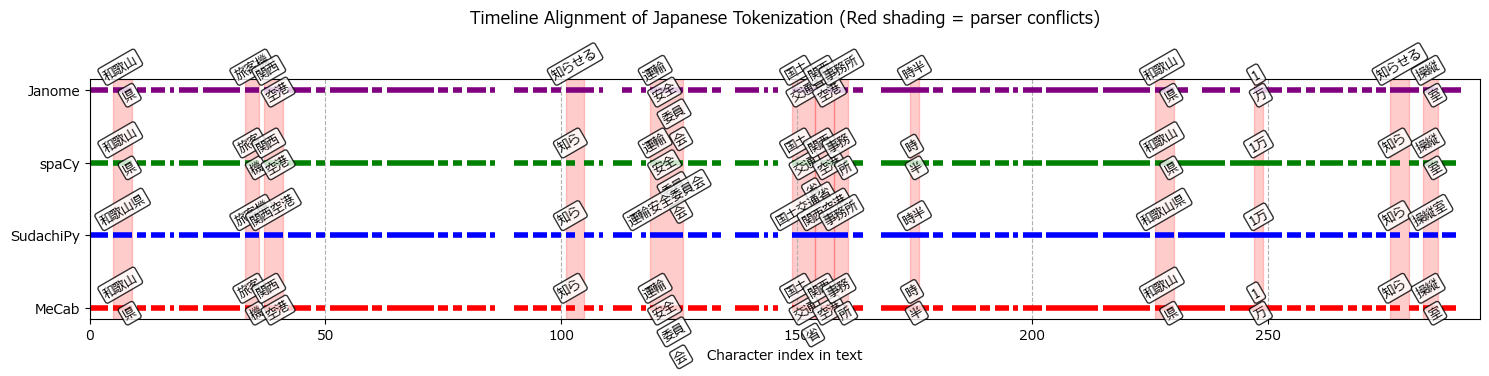

*** Overlapping Regions ***
Number of overlapping regions: 13

Indices 5-9
	Text: '和歌山県'
		Span (5, 8):
			Janome: 和歌山
			spaCy: 和歌山
			MeCab: 和歌山
		Span (5, 9):
			SudachiPy: 和歌山県
		Span (8, 9):
			spaCy: 県
			Janome: 県
			MeCab: 県

Indices 33-36
	Text: '旅客機'
		Span (33, 35):
			spaCy: 旅客
			MeCab: 旅客
		Span (33, 36):
			SudachiPy: 旅客機
			Janome: 旅客機
		Span (35, 36):
			MeCab: 機
			spaCy: 機

Indices 37-41
	Text: '関西空港'
		Span (37, 39):
			Janome: 関西
			MeCab: 関西
			spaCy: 関西
		Span (37, 41):
			SudachiPy: 関西空港
		Span (39, 41):
			Janome: 空港
			spaCy: 空港
			MeCab: 空港

Indices 101-105
	Text: '知らせる'
		Span (101, 103):
			SudachiPy: 知ら
			spaCy: 知ら
			MeCab: 知ら
		Span (101, 105):
			Janome: 知らせる

Indices 119-126
	Text: '運輸安全委員会'
		Span (119, 121):
			Janome: 運輸
			spaCy: 運輸
			MeCab: 運輸
		Span (119, 126):
			SudachiPy: 運輸安全委員会
		Span (121, 123):
			spaCy: 安全
			Janome: 安全
			MeCab: 安全
		Span (123, 125):
			spaCy: 委員
			Janome: 委員
			MeCab: 委員
		Span (125, 126):
			Janome: 会
			MeCab: 会
		

In [14]:
def spans_overlap(span1, span2):
    """Check if two spans (start, end) overlap."""
    return span1[0] < span2[1] and span2[0] < span1[1]

methods = parsers['method'].unique()

def timeline_plot(dataframe):

    fig, ax = plt.subplots(figsize=(15, len(methods)))

    parser_data = {}
    for i, method in enumerate(methods):
        temp_df = dataframe[(dataframe['method'] == method) & dataframe['major_pos'].isin(important_major_pos)]

        parser_data[method] = []

        # compile start and end indices of words from each parser
        for _, row in temp_df.iterrows():
            token = row['surface']
            start = row['index']
            end = start + len(token)

            parser_data[method].append({
                'start': start,
                'end': end,
                'surface': token,
                'lemma': row['lemma']
            })

            # Plot the token
            ax.plot([start, end], [i, i], color=parser_colors[method], lw=4, solid_capstyle="butt")

    # For each span, collect parsers that have tokens covering that span
    span_methods = defaultdict(list)
    for method, data in parser_data.items():
        for d in data:
            span = (d['start'], d['end'])
            span_methods[span].append({
                'method': method,
                'surface': d['surface'],
                'lemma': d['lemma']
            })

    return span_methods, parser_data, fig, ax


# Get span_methods from the timeline_plot function
span_methods, parser_data, fig, ax = timeline_plot(parsers)

# gather together the overlapping spans
# if separate spans overlap, then the same text was parsed differently
surface_overlapping_spans = set()

for span1, methods1 in span_methods.items():
    for span2, methods2 in span_methods.items():
        # skip if spans don't overlap
        if not spans_overlap(span1, span2) or (span1 == span2): # don't need to add identical spans to overlap
            continue

        for m in methods1:
            surface_overlapping_spans.add((span1, m['surface'], m['method']))
        for m in methods2:
            surface_overlapping_spans.add((span2, m['surface'], m['method']))

# group together overlapping spans into their own regions
spans_list = sorted(list(surface_overlapping_spans), key=lambda x: x[0])

overlapping_regions = []
if spans_list:
    current_end = spans_list[0][0][1]
    current_region = [spans_list[0]]

    for data in spans_list[1:]:
        (start, end), surface, method = data
        if start < current_end:
            current_region.append(data)
            current_end = max(current_end, end)
        else:
            overlapping_regions.append(current_region)
            current_region = [data]
            current_end = end

    overlapping_regions.append(current_region)

    for region in overlapping_regions:
        # highlight overlapping regions
        region_start = min(span[0] for span, _, _ in region)
        region_end = max(span[1] for span, _, _ in region)
        ax.axvspan(region_start, region_end, alpha=0.2, color='red', zorder=0)

        # group tokens by method for this region
        method_tokens = defaultdict(set)
        for (start, end), token, _ in region:
            # add tokens from all methods that cover this span
            for method_info in span_methods[(start, end)]:
                method = method_info['method']
                method_tokens[method].add((start, end, method_info['surface']))

        # add labels for each method's tokens in this region
        for method, tokens in method_tokens.items():
            method_index = list(methods).index(method)
            tokens = sorted(list(tokens), key=lambda x: x[0])

            for i, token_info in enumerate(tokens):
                start, end, token = token_info[0], token_info[1], token_info[2]

                position = method_index + 0.1 - (i * 0.30)

                ax.text((start + end) / 2, position, token,
                        ha="center", va="bottom", fontsize=9, rotation=30,
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

ax.set_yticks(range(len(methods)))
ax.set_yticklabels(methods)
ax.set_xlabel("Character index in text")
ax.set_title("Timeline Alignment of Japanese Tokenization (Red shading = parser conflicts)", pad=40)
ax.set_xlim(0, len(text))
ax.grid(True, axis='x', linestyle='--')

plt.tight_layout()
plt.show()

print("*** Overlapping Regions ***")
print(f"Number of overlapping regions: {len(overlapping_regions)}")
for region in overlapping_regions:
    region_start = min(span[0] for span, _, _ in region)
    region_end = max(span[1] for span, _, _ in region)
    print(f"\nIndices {region_start}-{region_end}")
    print(f"\tText: '{text[region_start:region_end]}'")

    overlaps = defaultdict(list)
    for span, surface, method in region:
        overlaps[span].append((method, surface))

    for span, method_data in overlaps.items():
        print(f'\t\tSpan {span}:')
        for method, surface in method_data:
            print(f'\t\t\t{method}: {surface}')


### Lemma Disagreements

- MeCab tends to use kanji forms in its lemmas, even for common words that are often written in kana (e.g. する → 為る, ある → 有る). However, there are a few instances where the surface form is in kanji and the lemma is in katakana (e.g. 工藤 → クドウ).
- SudachiPy and spaCy have a lot of agreement in how they lemmatize text, often using modern kana spellings.
- Similar to SudachiPy and spaCy, Janome uses modern kana spellings in its lemmas. However, one glaring oddity that I caught was that it pulled ほん out of にほんご, and then lemmatized it to ほる.

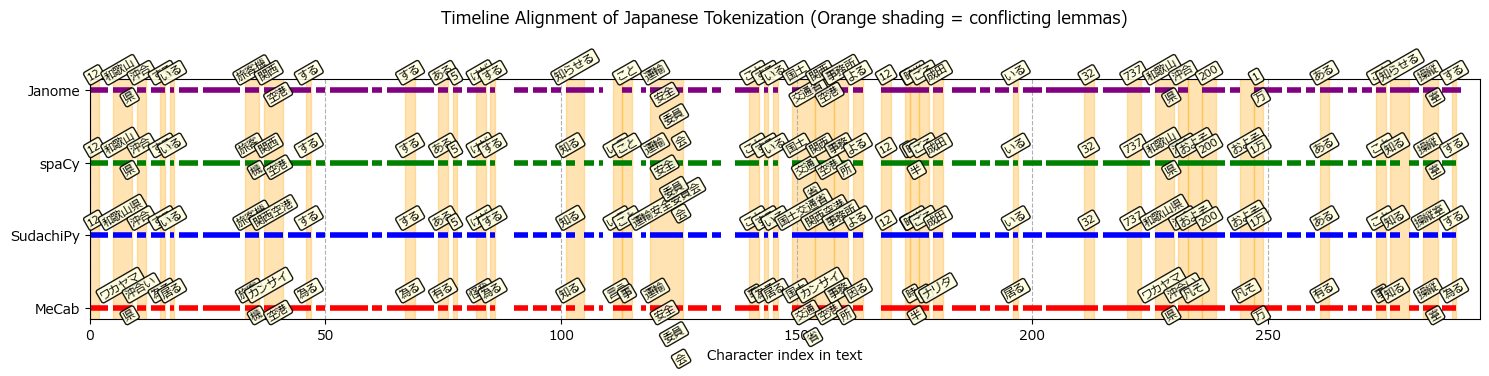

*** Conflicting Lemma Regions ***
Number of conflicting lemma regions: 43

Indices 0-2
	Text: '12'
		Span (0, 2):
			Janome: '12' → '12'
			MeCab: '12' → 'None'
			SudachiPy: '12' → '12'
			spaCy: '12' → '12'

Indices 5-9
	Text: '和歌山県'
		Span (5, 8):
			spaCy: '和歌山' → '和歌山'
			Janome: '和歌山' → '和歌山'
			MeCab: '和歌山' → 'ワカヤマ'
		Span (5, 9):
			SudachiPy: '和歌山県' → '和歌山県'
		Span (8, 9):
			MeCab: '県' → '県'
			spaCy: '県' → '県'
			Janome: '県' → '県'

Indices 10-12
	Text: '沖合'
		Span (10, 12):
			SudachiPy: '沖合' → '沖合'
			spaCy: '沖合' → '沖合'
			Janome: '沖合' → '沖合'
			MeCab: '沖合' → '沖合い'

Indices 15-16
	Text: 'し'
		Span (15, 16):
			Janome: 'し' → 'する'
			MeCab: 'し' → '為る'
			spaCy: 'し' → 'する'
			SudachiPy: 'し' → 'する'

Indices 17-18
	Text: 'い'
		Span (17, 18):
			MeCab: 'い' → '居る'
			Janome: 'い' → 'いる'
			spaCy: 'い' → 'いる'
			SudachiPy: 'い' → 'いる'

Indices 33-36
	Text: '旅客機'
		Span (33, 36):
			SudachiPy: '旅客機' → '旅客機'
			Janome: '旅客機' → '旅客機'
		Span (33, 35):
			spaCy: '旅客' → '旅客'
			MeCab: '旅客' 

In [15]:
span_methods, parser_data, fig, ax = timeline_plot(parsers)

# find spans where multiple parsers have overlapping tokens but different lemmas
lemma_overlapping_spans = set()

# check all pairs of spans for overlap
for span1, methods1 in span_methods.items():
    lemmas = {m1['lemma'] for m1 in methods1}

    # if there are different lemmas in the same span, add to overlap
    if len(lemmas) > 1:
        for m1 in methods1:
            lemma_overlapping_spans.add((span1, m1['method'], m1['surface'], m1['lemma']))

    # compare spans against each other to see if they overlap
    for span2, methods2 in span_methods.items():
        if not spans_overlap(span1, span2) or (span1 == span2): # already looked at identical spans, so can ignore those
            continue
        # if they do overlap, and methods and lemmas are different, add to overlap
        for d1 in methods1:
            for d2 in methods2:
                if (d1['method'] != d2['method']) and (d1['lemma'] != d2['lemma']):
                    lemma_overlapping_spans.add((span1, d1['method'], d1['surface'], d1['lemma']))
                    lemma_overlapping_spans.add((span2, d2['method'], d2['surface'], d2['lemma']))

# group overlapping spans into regions
spans_list = sorted(list(lemma_overlapping_spans), key=lambda x: x[0][0])

lemma_conflicting_regions = []
if spans_list:
    current_end = spans_list[0][0][1]
    current_region = [spans_list[0]]

    for span_data in spans_list[1:]:
        (start, end), _, _, _ = span_data

        if start < current_end:
            current_region.append(span_data)
            current_end = max(current_end, end)
        else:
            lemma_conflicting_regions.append(current_region)
            current_region = [span_data]
            current_end = end

    lemma_conflicting_regions.append(current_region)

    # highlight and label regions
    for region in lemma_conflicting_regions:
        # highlight the region
        region_start = min(span[0] for span, _, _, _ in region)
        region_end = max(span[1] for span, _, _, _ in region)
        ax.axvspan(region_start, region_end, alpha=0.3, color='orange', zorder=0)

        # group by method for labeling
        method_data = defaultdict(list)
        for span, method, _, lemma in region:
            start, end = span
            method_data[method].append({
                'start': start,
                'end': end,
                'lemma': lemma
            })

        # add labels for each method's lemmas in this region
        for method, data_list in method_data.items():
            method_index = list(methods).index(method)

            data_list.sort(key=lambda d: d['start'])
            for i, data in enumerate(data_list):
                start = data['start']
                end = data['end']
                lemma = data['lemma']

                position = method_index + 0.1 - (i * 0.30)

                ax.text((start + end) / 2, position, lemma,
                        ha="center", va="bottom", fontsize=8, rotation=30,
                        bbox=dict(boxstyle="round,pad=0.2", facecolor='lightyellow', alpha=0.9))

ax.set_yticks(range(len(methods)))
ax.set_yticklabels(methods)
ax.set_xlabel("Character index in text")
ax.set_title("Timeline Alignment of Japanese Tokenization (Orange shading = conflicting lemmas)", pad=40)
ax.set_xlim(0, len(text))
ax.grid(True, axis='x', linestyle='--')

plt.tight_layout()
plt.show()

# Print information about lemma conflicts
print("*** Conflicting Lemma Regions ***")
print(f"Number of conflicting lemma regions: {len(lemma_conflicting_regions)}")
for region in lemma_conflicting_regions:
    region_start = min(span[0] for span, _, _, _ in region)
    region_end = max(span[1] for span, _, _, _ in region)
    print(f"\nIndices {region_start}-{region_end}")
    print(f"\tText: '{text[region_start:region_end]}'")

    # group by unique spans and show different lemmas
    span_lemmas = defaultdict(list)
    for span, method, surface, lemma in region:
        span_lemmas[span].append((method, surface, lemma))

    for span, method_data in span_lemmas.items():
        print(f"\t\tSpan {span}:")
        for method, surface, lemma in method_data:
            print(f"\t\t\t{method}: '{surface}' → '{lemma}'")

# Appendix

This section is full of visualizations that I thought might be useful, but weren't, or those that I wanted to see, regardless of their utility.

## Major and Minor Parts of Speech

These bar charts show the counts of the parts of speech of the lemmas in the exclusive subsets and intersections indicated in each chart's title. These charts were mildly interesting, though I didn't gain any extra insight from them. The total bar chart earlier in this notebook showing total part-of-speech counts was much more useful.

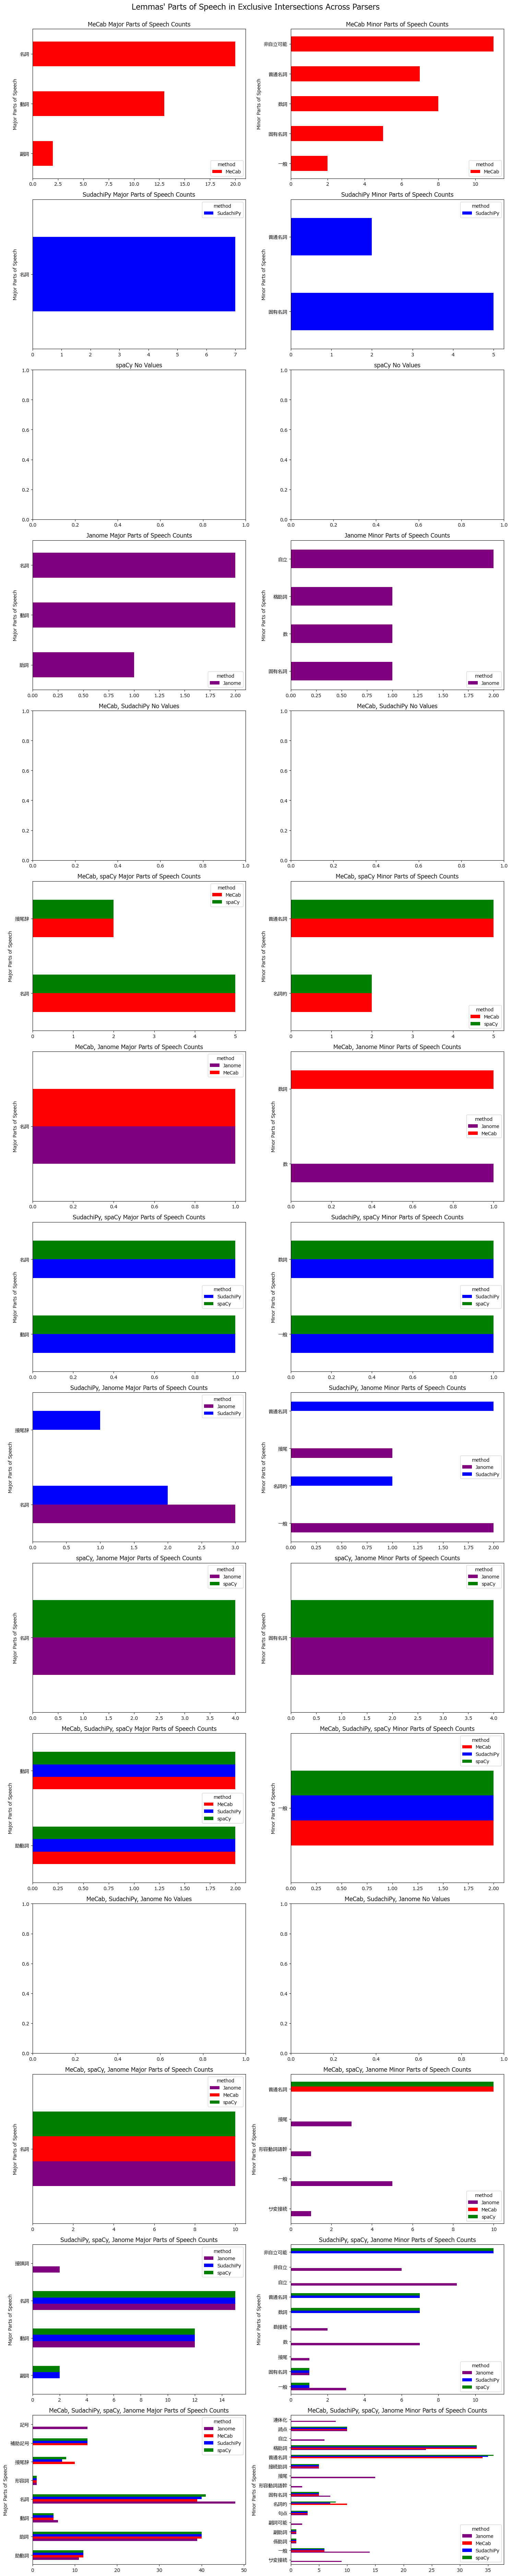

In [16]:
# filter the dataframe using UpSet logic
def method_combinations_filter(df, combination):
    def check_match(row):
        row_methods = {row['method']}
        if row['other_methods'] is not None:
            row_methods.update(row['other_methods'])
        return row_methods == set(combination)

    return df[df.apply(check_match, axis=1)]

method_combinations = []
for r in range(1, parsers['method'].nunique()+1):
    for methods in itertools.combinations(parsers['method'].unique(), r):
        method_combinations.append(methods)

combinations = 2 ** parsers['method'].nunique() - 1

fig, ax = plt.subplots(nrows=combinations, ncols=2, figsize=(15, 5*combinations))

for i, methods in enumerate(method_combinations):
    temp_df = method_combinations_filter(parsers, methods)

    if temp_df.empty:
        ax[i, 0].set_title(f'{', '.join(methods)} No Values')
        ax[i, 1].set_title(f'{', '.join(methods)} No Values')
        continue
    else:
        ax[i, 0].set_title(f'{', '.join(methods)} Major Parts of Speech Counts')
        ax[i, 1].set_title(f'{', '.join(methods)} Minor Parts of Speech Counts')

        temp_major_crosstab = pd.crosstab(temp_df['major_pos'], temp_df['method'])
        temp_minor_crosstab = pd.crosstab(temp_df['minor_pos'], temp_df['method'])

        major_colors = [parser_colors[method] for method in temp_major_crosstab.columns]
        minor_colors = [parser_colors[method] for method in temp_minor_crosstab.columns]

        temp_major_crosstab.plot(kind='barh', color=major_colors, ax=ax[i, 0])
        temp_minor_crosstab.plot(kind='barh', color=minor_colors, ax=ax[i, 1])

        ax[i, 0].set_ylabel('Major Parts of Speech')
        ax[i, 1].set_ylabel('Minor Parts of Speech')

fig.suptitle('Lemmas\' Parts of Speech in Exclusive Intersections Across Parsers', fontsize=16, y=1)

plt.tight_layout()
plt.show()

## Conjugation Types and Forms

Like with minor parts of speech, I think there's opportunity for further analysis just on the level of conjugation data. As it is now, however, the parsers don't seem to agree on the different conjugation labels (Janome especially seems to have a system nearly entirely its own). For that reason, these plots weren't helpful, though I'm not convinced they would've helped me much even if I were to map all the labels together.

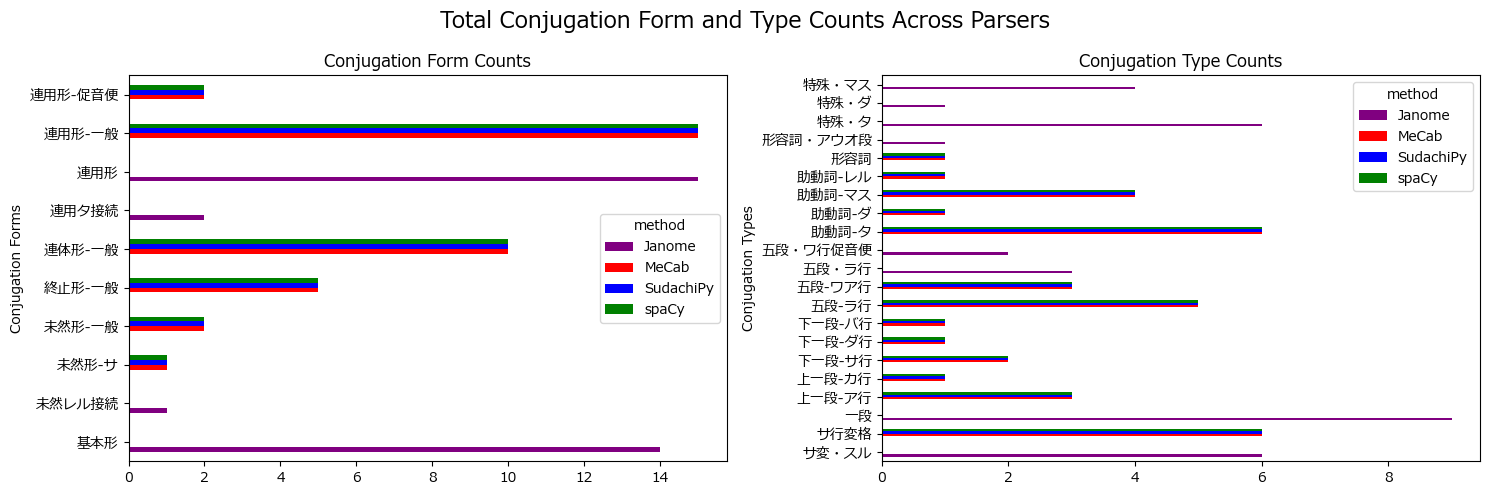

In [17]:
def conjugation_bar_plots(dataframe):
    methods = dataframe['method'].unique()

    if len(methods) < 1:
        raise ValueError('Need at least 1 parser')

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    con_form_crosstab = pd.crosstab(dataframe['conjugation_form'], dataframe['method'])
    con_type_crosstab = pd.crosstab(dataframe['conjugation_type'], dataframe['method'])

    con_form_colors = [parser_colors[method] for method in con_form_crosstab.columns]
    con_type_colors = [parser_colors[method] for method in con_type_crosstab.columns]

    con_form_crosstab.plot(kind='barh', title='Conjugation Form Counts', color=con_form_colors, ax=ax[0])
    con_type_crosstab.plot(kind='barh', title='Conjugation Type Counts', color=con_type_colors, ax=ax[1])

    ax[0].set_ylabel('Conjugation Forms')
    ax[1].set_ylabel('Conjugation Types')

    plt.suptitle('Total Conjugation Form and Type Counts Across Parsers', fontsize=16)

    plt.tight_layout()
    plt.show()

conjugation_bar_plots(parsers)

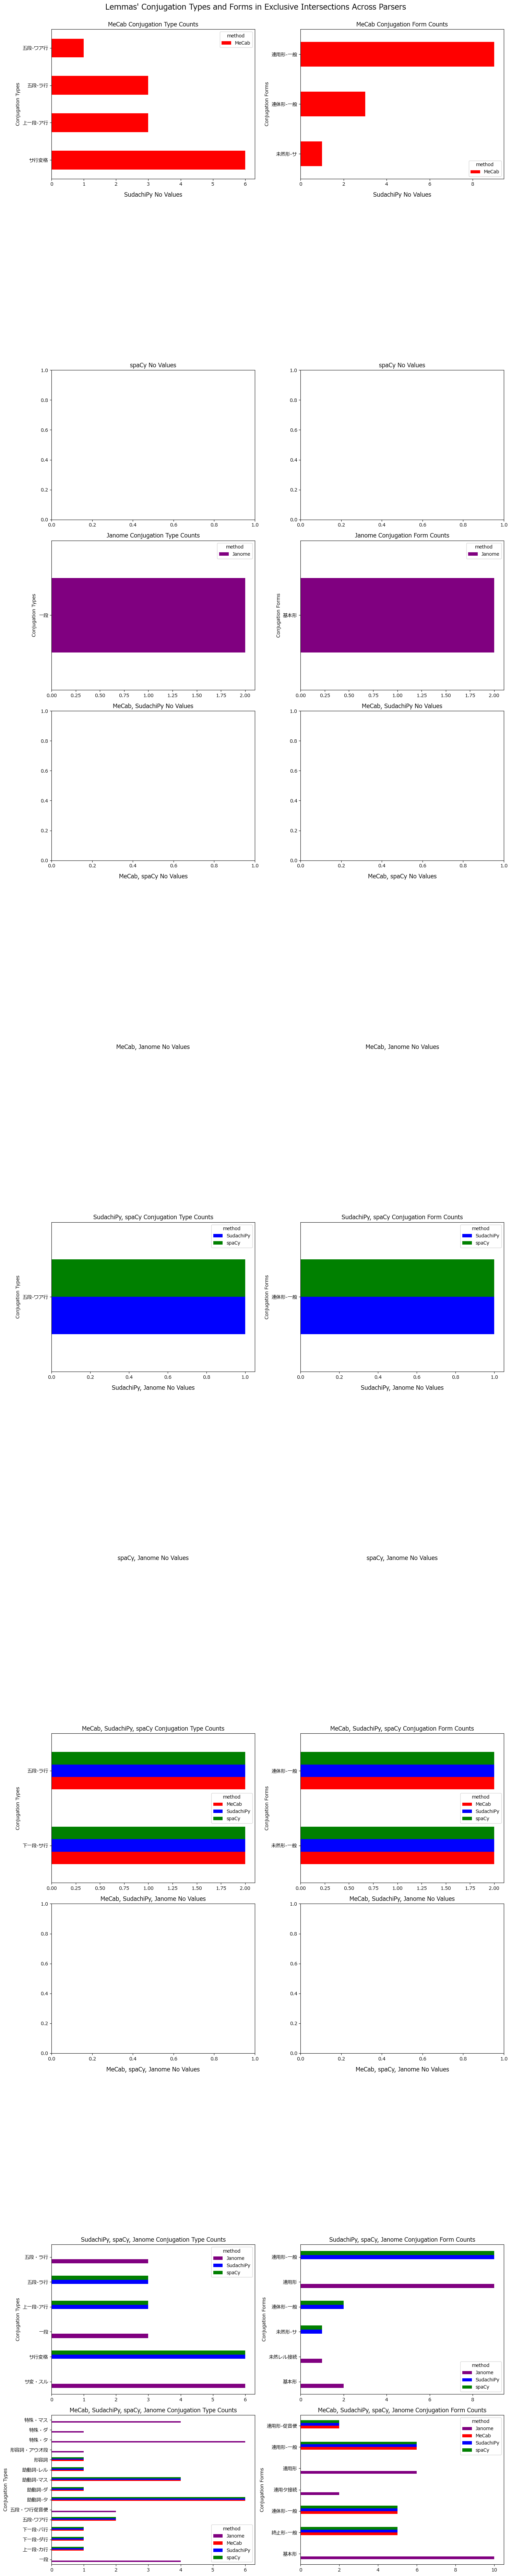

In [18]:
fig, ax = plt.subplots(nrows=combinations, ncols=2, figsize=(15, 5*combinations))

for i, methods in enumerate(method_combinations):
    temp_df = method_combinations_filter(parsers, methods)

    if temp_df.empty:
        ax[i, 0].set_title(f'{', '.join(methods)} No Values')
        ax[i, 1].set_title(f'{', '.join(methods)} No Values')
        continue
    else:
        ax[i, 0].set_title(f'{', '.join(methods)} Conjugation Type Counts')
        ax[i, 1].set_title(f'{', '.join(methods)} Conjugation Form Counts')

        temp_conj_type = pd.crosstab(temp_df['conjugation_type'], temp_df['method'])
        temp_form_type = pd.crosstab(temp_df['conjugation_form'], temp_df['method'])

        # handle empty crosstab dataframes
        for df, axis, title, ylabel in [
            (temp_conj_type, ax[i, 0], "Conjugation Type Counts", "Conjugation Types"),
            (temp_form_type, ax[i, 1], "Conjugation Form Counts", "Conjugation Forms")
        ]:
            try:
                temp_colors = [parser_colors[method] for method in df.columns]
                df.plot(kind="barh", color=temp_colors, ax=axis)
                axis.set_title(f"{', '.join(methods)} {title}")
                axis.set_ylabel(ylabel)
            except TypeError:
                axis.set_title(f"{', '.join(methods)} No Values")
                axis.axis("off")

        ax[i, 0].set_ylabel('Conjugation Types')
        ax[i, 1].set_ylabel('Conjugation Forms')

fig.suptitle('Lemmas\' Conjugation Types and Forms in Exclusive Intersections Across Parsers', fontsize=16, y=1)

plt.tight_layout()
plt.show()

## Pairwise Comparison of Lemma Sets

Here, I compare the unique lemma sets produced by each parser. For every pair of parsers, this cell:

- Prints the size of each lemma set.
- Shows the intersection (lemmas shared by both parsers).
- Lists the exclusive lemmas (present in one parser but not the other).

I wrote this cell when I was looking at only two parsers. Once I added more, it was no longer as useful.

In [19]:
def pairwise_compare(dataframe):
    if dataframe['method'].nunique() < 2:
        raise ValueError('Need at least 2 parsers')

    lemma_sets =  {
        method: set(dataframe.loc[(dataframe['method'] == method) & (dataframe['major_pos'].isin(important_major_pos)), 'lemma'])
        for method in dataframe['method'].unique()
    }

    for name, lemmas in lemma_sets.items():
        print(f'{name} length: {len(lemmas)}')
    print()

    intersection = {}
    df1_only = {}
    df2_only = {}
    for (name1, lemmas1), (name2, lemmas2) in itertools.combinations(lemma_sets.items(), 2):
        intersection[(name1, name2)] = lemmas1.intersection(lemmas2)
        df1_only[(name1, name2)] = lemmas1 - lemmas2
        df2_only[(name1, name2)] = lemmas2 - lemmas1

    for (name1, name2), inter in intersection.items():
        print(f'{name1} and {name2} ({len(inter)} items):\n{inter}\n')
    print()

    for (name1, name2) in df1_only:
        only1 = df1_only[(name1, name2)]
        only2 = df2_only[(name1, name2)]
        print(f'{len(only1)} {name1} words not in {name2}:\n{only1}\n')
        print(f'{len(only2)} {name2} words not in {name1}:\n{only2}\n')

pairwise_compare(parsers)

MeCab length: 70
SudachiPy length: 66
spaCy length: 75
Janome length: 72

MeCab and SudachiPy (40 items):
{'上空', '便', '軽い', '貨物', '夜', '午後', '飛行', '中', 'キロ', '使う', '調べる', 'ユナイテッド', 'ボーイング', 'セブ', '起きる', '火災', 'シューター', '室', '乗客', '緊急', '国', '出る', '機', 'アメリカ', 'メートル', '脱出', '向かう', '用', '後部', 'トラブル', 'フィリピン', '表示', '知る', '航空', '警報', '原因', '人', '型', '日', '着陸'}

MeCab and spaCy (55 items):
{'会', '操縦', '半', '便', '安全', '上空', '軽い', '夜', '貨物', '午後', '飛行', '空港', '中', '交通', '時', 'キロ', '使う', '調べる', 'ユナイテッド', '国土', 'ボーイング', 'セブ', '起きる', '火災', 'シューター', '室', '県', '委員', '緊急', '乗客', '国', '事務', '機', '出る', 'アメリカ', 'メートル', '脱出', '向かう', '用', '運輸', '所', '後部', '旅客', 'トラブル', 'フィリピン', '表示', '省', '知る', '航空', '警報', '原因', '人', '型', '日', '着陸'}

MeCab and Janome (48 items):
{'会', '操縦', '上空', '安全', '便', '軽い', '夜', '貨物', '午後', '飛行', '空港', '中', 'キロ', '使う', '調べる', 'ユナイテッド', '国土', 'ボーイング', 'セブ', '起きる', '火災', 'シューター', '室', '県', '委員', '緊急', '乗客', '万', '国', '機', '出る', 'アメリカ', 'メートル', '脱出', '向かう', '用', '運輸', '後部', 'トラブル', '

## Word Clouds

Interesting, but not useful.

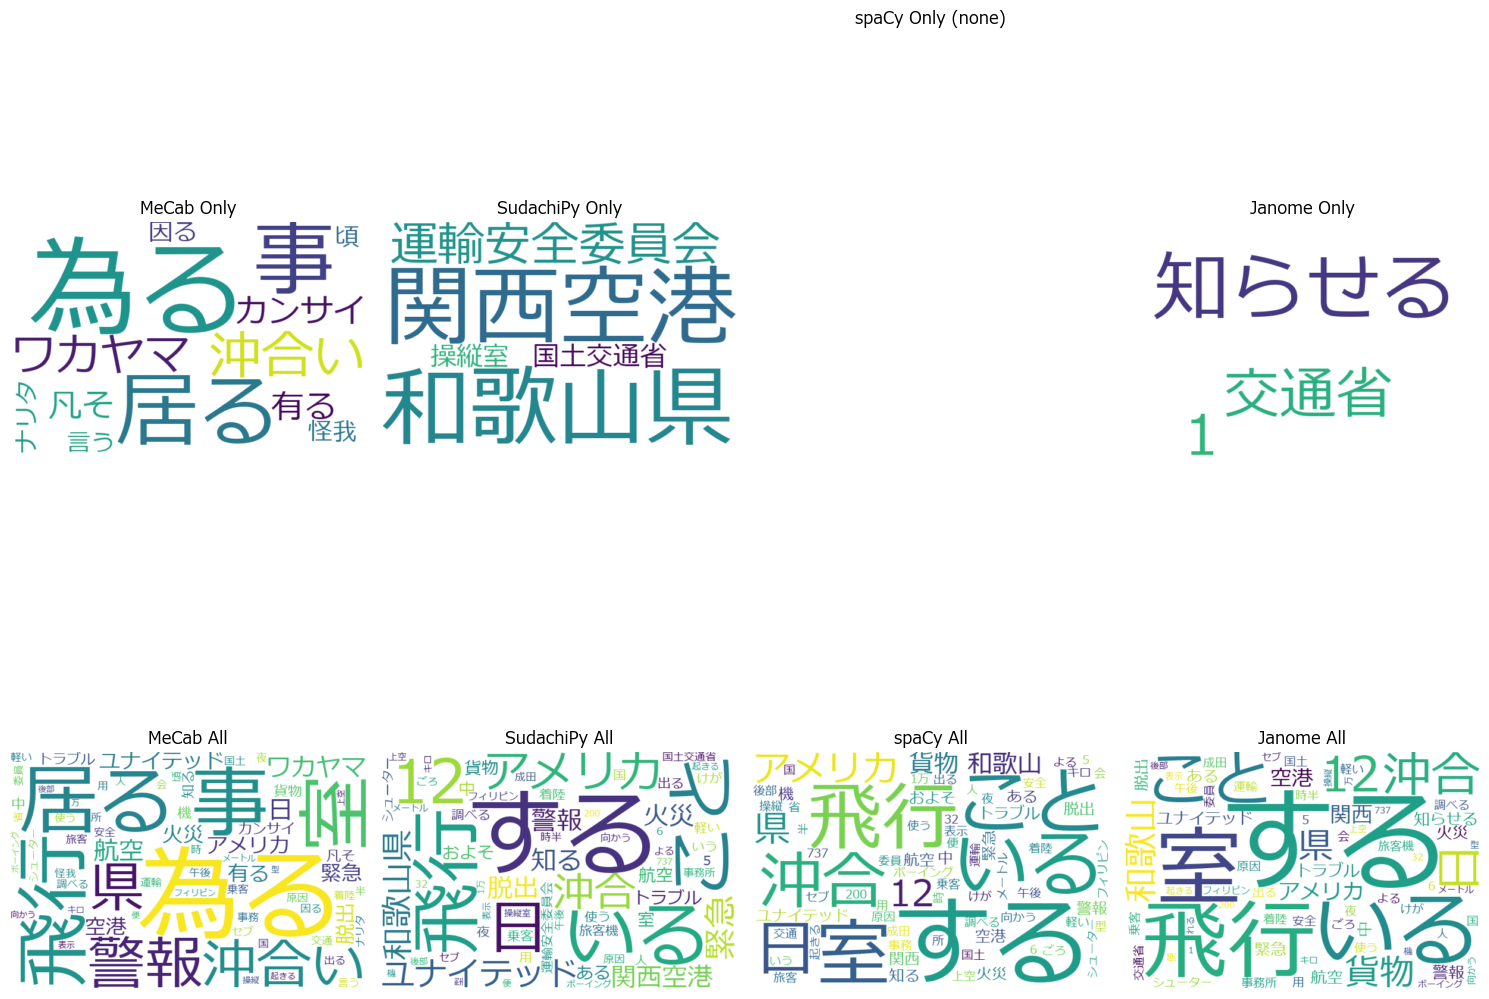

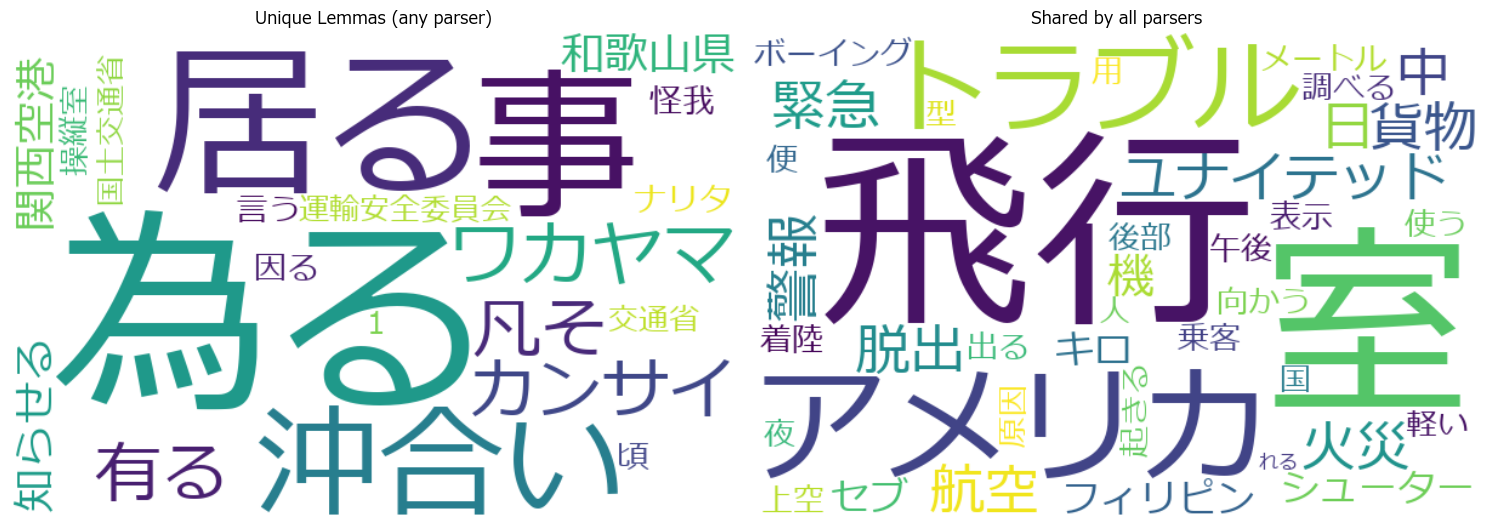

In [20]:
def make_cloud(word_freq, title, ax):
    if word_freq.empty:
        ax.set_title(f"{title} (none)")
        ax.axis("off")
        return
    wc = WordCloud(
        width=600, height=400, background_color="white",
        font_path='meiryo.ttc'
    ).generate_from_frequencies(word_freq.to_dict())
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(title)
    ax.axis("off")

methods = parsers['method'].unique()
all_methods = set(methods)

fig1, ax1 = plt.subplots(2, len(methods), figsize=(15, 3 * (len(methods))))

# per parser word clouds
for i, method in enumerate(methods):
    df = parsers[(parsers['method'] == method) & (parsers['major_pos'].isin(important_major_pos))]
    # lemmas extracted by only this parser
    unique_counts = df[df['other_methods'].isna()]['lemma'].value_counts()
    # all lemmas extracted by this parser
    all_counts = df['lemma'].value_counts()
    make_cloud(unique_counts, f"{method} Only", ax1[0, i])
    make_cloud(all_counts, f"{method} All", ax1[1, i])

plt.tight_layout()
plt.show()


fig2, ax2 = plt.subplots(1, 2, figsize=(15, 6))
# lemmas seen by only 1 parser
unique_global = parsers[parsers['other_methods'].isna() & parsers['major_pos'].isin(important_major_pos)]['lemma'].value_counts()

# lemmas seen by all parsers
shared_all_global = parsers[
    parsers['other_methods'].apply(lambda x: isinstance(x, list) and len(x) == len(all_methods) - 1) &
    parsers['major_pos'].isin(important_major_pos)
].groupby('lemma').size()

make_cloud(unique_global, "Unique Lemmas (any parser)", ax2[0])
make_cloud(shared_all_global, "Shared by all parsers", ax2[1])

plt.tight_layout()
plt.show()

## Pivot Table

I said at the introduction to this Appendix that these visualizations weren't useful in my analysis. That's not quite true for this pivot table. Picking through this table and looking at individual instances helped me get an idea of what "big picture" information I needed to explore further. I've put it in the Appendix, however, because picking through a table isn't good UX.

In [21]:
pivoted = parsers.pivot(index='index', columns='method', values=['lemma', 'major_pos', 'minor_pos'])
pivoted.columns = [f"{parser}_{field}" for field, parser in pivoted.columns]
pivoted = pivoted.reset_index()

kwic_df = parsers[['index', 'KWIC']].drop_duplicates('index')
pivoted = pivoted.merge(kwic_df, on='index', how='left')

cols_order = ["KWIC"] + [c for c in pivoted.columns if c != "KWIC"]
cols_order.remove('index')
pivoted[pivoted['index'].isin(parsers.loc[parsers['other_methods'].isna(), 'index'].unique())][cols_order]

,KWIC,Janome_lemma,MeCab_lemma,SudachiPy_lemma,spaCy_lemma,Janome_major_pos,MeCab_major_pos,SudachiPy_major_pos,spaCy_major_pos,Janome_minor_pos,MeCab_minor_pos,SudachiPy_minor_pos,spaCy_minor_pos
0,12日夜、和歌山,12,None,12,12,名詞,名詞,名詞,名詞,数,数詞,数詞,数詞
4,和歌山県の沖合を,和歌山,ワカヤマ,和歌山県,和歌山,名詞,名詞,名詞,名詞,固有名詞,固有名詞,固有名詞,固有名詞
7,沖合を飛行してい,沖合,沖合い,沖合,沖合,名詞,名詞,名詞,名詞,一般,普通名詞,普通名詞,普通名詞
10,していたアメリカ,する,為る,する,する,動詞,動詞,動詞,動詞,自立,非自立可能,非自立可能,非自立可能
12,いたアメリカのユ,いる,居る,いる,いる,動詞,動詞,動詞,動詞,非自立,非自立可能,非自立可能,非自立可能
22,関西空港に緊急着,関西,カンサイ,関西空港,関西,名詞,名詞,名詞,名詞,固有名詞,固有名詞,固有名詞,固有名詞
27,し、乗客が脱出用,する,為る,する,する,動詞,動詞,動詞,動詞,自立,非自立可能,非自立可能,非自立可能
39,するトラブルがあ,する,為る,する,する,動詞,動詞,動詞,動詞,自立,非自立可能,非自立可能,非自立可能
42,あり、5人が軽い,ある,有る,ある,ある,動詞,動詞,動詞,動詞,自立,非自立可能,非自立可能,非自立可能
44,5人が軽いけがを,5,None,5,5,名詞,名詞,名詞,名詞,数,数詞,数詞,数詞
